## Non-Convex Production Function 

### Skiba (1978)

$$ F(k) = max\{F_L(k),F_H(k)\}$$
$$ F_L(k) = A_Lk^α $$
$$ F_H(k) = A_H((k −\kappa)^+)^α$$

with $κ > 0$, $AH > AL$ 

In [211]:
def F(k, AL = 0.5, AH = 1.0, α = 1/3, κ = 2):
    FL = AL*k**α
    FH = AH*np.maximum(k - kappa,0)**α
    return np.maximum(FL, FH)

In [212]:
import numpy as np

k = np.linspace(0,6, 100)

y = F(k)

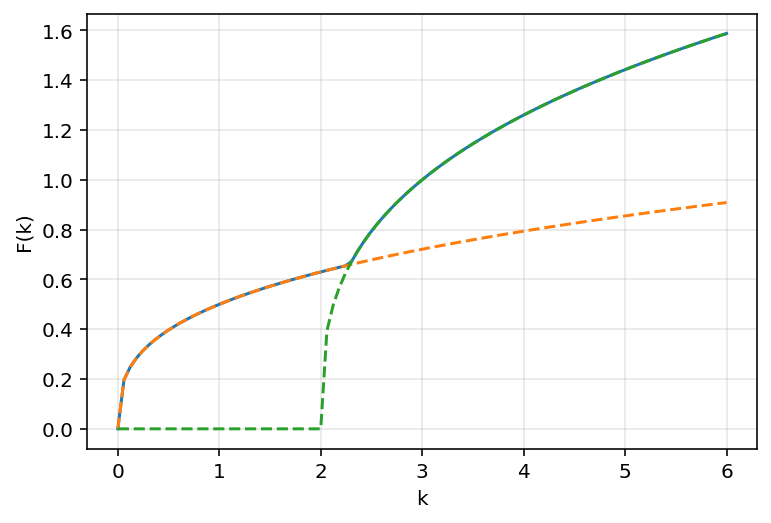

In [213]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.plot(k, y)
plt.plot(k, 0.5*k**(1/3), 
        '--')
plt.plot(k, 1.0*np.maximum(k - 2, 0)**(1/3), 
        '--')
plt.ylabel(r'F(k)')
plt.xlabel('k')
plt.grid(alpha=0.3)
plt.show()

In [214]:
import scipy.sparse as sparse
from scipy.sparse.linalg import inv
from time import time

Value Function Converged, Iteration = 111 in 0.51 seconds


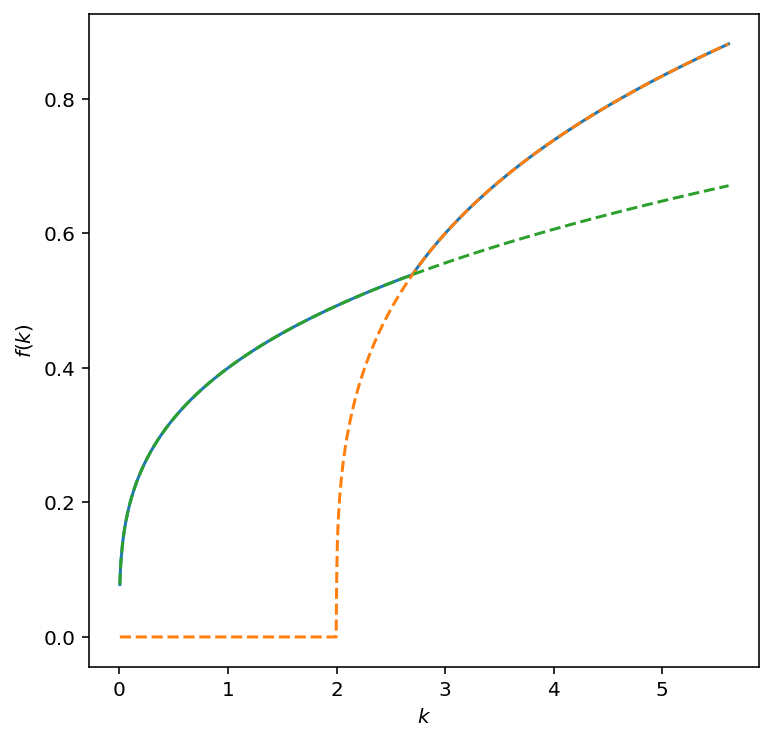

In [219]:
s = 2
a = 0.3
r = 0.05
d = 0.05
AH = 0.6
AL = 0.4
kappa = 2 #fixed cost

kssH = (a*AH/(r+d))**(1/(1-a)) + kappa
kstar = kappa/(1-(AL/AH)**(1/a))

I = 1000
kmin = 0.001*kssH
kmax = 1.3*kssH
k = np.linspace(kmin,kmax,I)
dk = (kmax-kmin)/(I-1)

#production function
yH = AH*np.maximum(k - kappa,0)**a
yL = AL*k**a
y = np.maximum(yH,yL)

plt.figure(figsize = (6,6))
plt.plot(k,y,k,yH,'--',k,yL,'--')
plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.savefig('Y_butterfly.pdf')


maxit=1000
crit = 10**(-6)
Delta = 1000

dVf = np.zeros(I)
dVb = np.zeros(I)
c = np.zeros(I)
dist = []

#INITIAL GUESS
v0 = (k**a)**(1-s)/(1-s)/r
v = v0

start = time()
for n in range(0,maxit):
    V = v
    # forward difference
    dVf[0:I-1] = (V[1:I]-V[0:I-1])/dk
    dVf[I-1] = (y[I-1] - d*kmax)**(-s) #state constraint, for stability
    # backward difference
    dVb[1:I] = (V[1:I]-V[0:I-1])/dk
    dVb[0] = (y[0] - d*kmin)**(-s) #state constraint, for stability
       
    #consumption and savings with forward difference
    cf = np.maximum(dVf,10**(-10))**(-1/s)
    muf = y - d*k - cf
    Hf = cf**(1-s)/(1-s) + dVf*muf
    
    #consumption and savings with backward difference
    cb = np.maximum(dVb,10**(-10))**(-1/s)
    mub = y - d*k - cb
    Hb = cb**(1-s)/(1-s) + dVb*mub
    
    #consumption and derivative of value function at steady state
    c0 = y - d*k
    dV0 = np.maximum(c0,10**(-10))**(-s)
    H0 = c0**(1-s)/(1-s)
    
    # dV_upwind makes a choice of forward or backward differences based on
    # the sign of the drift    
    Ineither = (1-(muf>0)) * (1-(mub<0))
    Iunique = (mub<0)*(1-(muf>0)) + (1-(mub<0))*(muf>0)
    Iboth = (mub<0)*(muf>0)
    Ib = Iunique*(mub<0) + Iboth*(Hb>=Hf)
    If = Iunique*(muf>0) + Iboth*(Hf>=Hb)
    I0 = Ineither
    
    #consumption
    c  = cf*If + cb*Ib + c0*I0
    u = c**(1-s)/(1-s)
    
    #CONSTRUCT MATRIX
    X = -Ib*mub/dk
    Y = -If*muf/dk + Ib*mub/dk
    Z = If*muf/dk
    
    #full matrix: slower
    #     for i=2:I-1
    #         A(i,i-1) = x(i)
    #         A(i,i) = y(i)
    #         A(i,i+1) = z(i)
    #     end
    #     A(1,1)=y(1) A(1,2) = z(1)
    #     A(I,I)=y(I) A(I,I-1) = x(I)
   
    #sparse matrix: faster
    A =sparse.spdiags(Y,0,I,I)+sparse.spdiags(X[1:I],-1,I,I)+sparse.spdiags(np.insert(Z[0:I-1],0,0),1,I,I)
    B = (r + 1/Delta)*sparse.eye(I) - A
    b = (u + V/Delta)
    V = sparse.linalg.spsolve(B, b) #SOLVE SYSTEM OF EQUATIONS
    Vchange = V - v
    v = V   
    
    dist.append( max(abs(Vchange)) )
    if dist[n]<crit:
        end = time()
        print('Value Function Converged, Iteration = %1.0f in %1.2f seconds' % (n, end-start))
        break


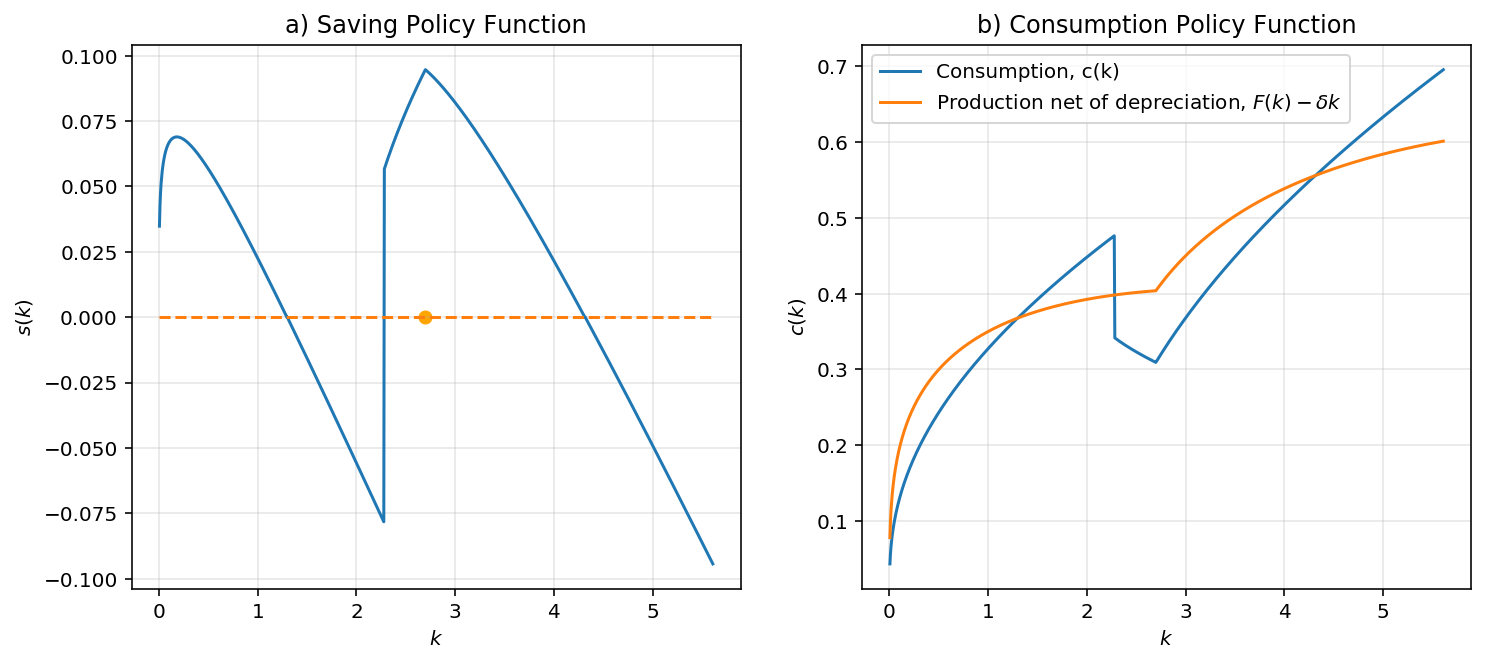

In [216]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(k, y - d*k -c)
ax[0].plot(k, np.zeros(len(k)), '--')
ax[0].scatter(kstar, 0, color = 'orange')
ax[0].set_xlabel(r'$k$')
ax[0].set_ylabel(r'$s(k)$')
ax[0].set_title(r'a) Saving Policy Function')
ax[0].grid(alpha=0.3)

ax[1].plot(k, c, label = r"Consumption, c(k)")
ax[1].plot(k, y-d*k, label = r'Production net of depreciation, $F(k)-\delta k$')
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel(r'$c(k)$')
ax[1].set_title(r'b) Consumption Policy Function')
ax[1].grid(alpha=0.3)
ax[1].legend()
plt.savefig('policy_functions.pdf')
plt.show()

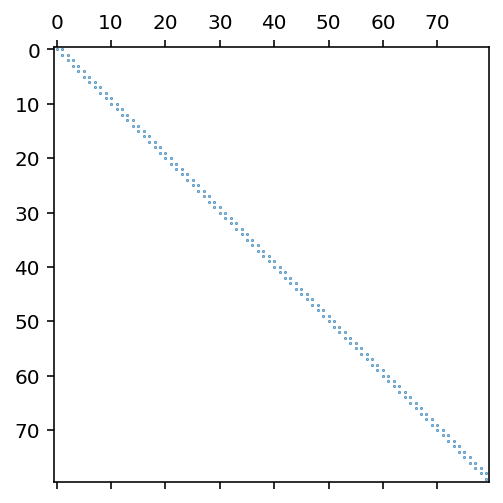

In [218]:
plt.spy(B[0:80, 0:80], markersize = 0.2)